In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
import logging
import string
import sys
import os

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import xarray as xr
from replay_trajectory_classification import ClusterlessClassifier

from src.figure_utilities import (
    set_figure_defaults,
    PAGE_HEIGHT,
    ONE_COLUMN,
    TWO_COLUMN,
    save_figure,
)
from src.parameters import TRANSITION_TO_CATEGORY, FIGURE_DIR

set_figure_defaults()

## Examples

In [3]:
import copy

from src.load_data import load_data
from src.parameters import (
    ANIMALS,
    PROBABILITY_THRESHOLD,
    PROCESSED_DATA_DIR,
    SAMPLING_FREQUENCY,
    TRANSITION_TO_CATEGORY,
    continuous_transition_types,
    discrete_diag,
    model,
    model_kwargs,
    movement_var,
    place_bin_size,
    replay_speed,
)
from loren_frank_data_processing import (
    get_multiunit_dataframe,
    get_multiunit_dataframe2,
)
from loren_frank_data_processing.position import (
    make_track_graph,
    EDGE_ORDER,
    EDGE_SPACING,
)
from src.figure3 import plot_clusterless_1D_results, plot_1D_projected_to_2D
from src.visualization import make_classifier_movie


def plot_ripple_figure_1D(
    epoch_key, ripple_numbers, is_save_figure=True, cmap="bone_r"
):
    if isinstance(ripple_numbers, int):
        ripple_numbers = [ripple_numbers]
    data_type, dim = "clusterless", "1D"
    animal, day, epoch = epoch_key
    data = load_data(epoch_key)

    multiunit_times = [
        get_multiunit_dataframe(tetrode_key, ANIMALS)
        for tetrode_key in data["tetrode_info"].index
    ]
    if multiunit_times[0] is None:
        multiunit_times = [
            get_multiunit_dataframe2(tetrode_key, ANIMALS)
            for tetrode_key in data["tetrode_info"].index
        ]

    # Fit
    is_training = data["position_info"].speed > 4
    position = data["position_info"].loc[:, "linear_position"]
    track_graph, center_well_id = make_track_graph(epoch_key, ANIMALS)

    model_name = os.path.join(
        PROCESSED_DATA_DIR, f"{animal}_{day:02}_{epoch:02}_{data_type}_{dim}_model.pkl"
    )
    classifier = ClusterlessClassifier.load_model(model_name)

    results = xr.open_dataset(
        os.path.join(PROCESSED_DATA_DIR, f"{animal}_{day:02d}_{epoch:02d}.nc"),
        group=f"/{data_type}/{dim}/classifier/ripples/",
    )

    for ripple_number in ripple_numbers:
        plot_clusterless_1D_results(
            multiunit_times,
            data,
            results.sel(ripple_number=ripple_number).dropna("time", how="all"),
            classifier,
            epoch_key,
            ripple_number,
            cmap=cmap,
            is_save_figure=is_save_figure,
        )
        make_classifier_movie(classifier, results, ripple_number, data, epoch_key)

Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Bond/bonDIO03.mat
No DIO file found, using distance from well to segment trials
Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Bond/bonDIO03.mat
No DIO file found, inferring correct inbound/outbound from task rules
Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Bond/bonDIO03.mat
No DIO file found, using distance from well to segment trials
Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Bond/bonDIO03.mat
No DIO file found, inferring correct inbound/outbound from task rules


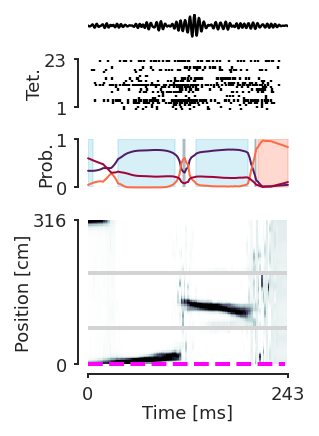

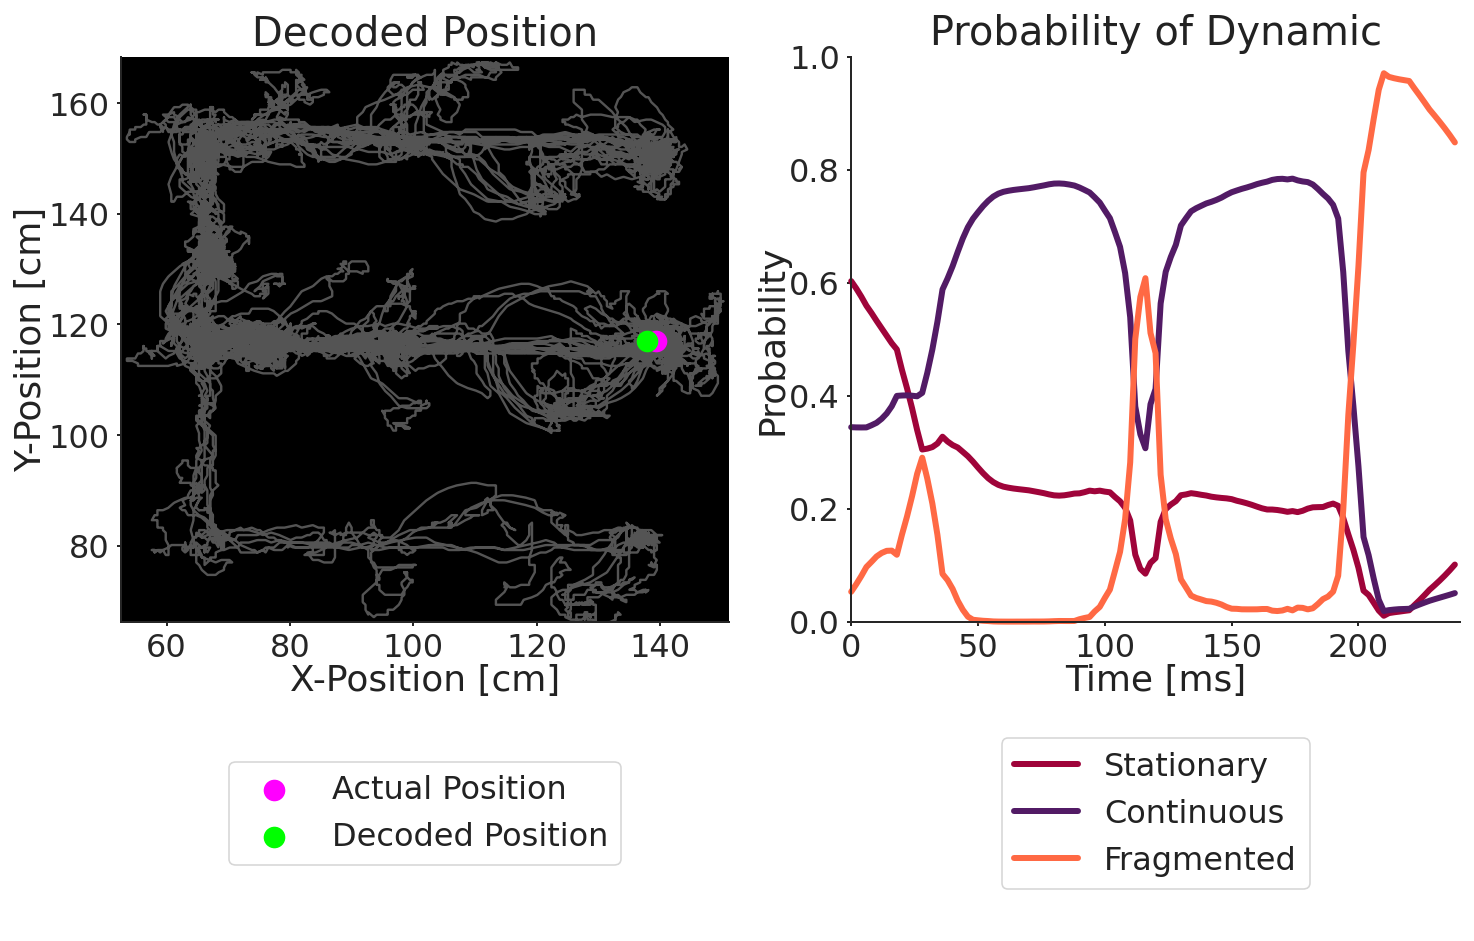

In [15]:
epoch_key = "bon", 3, 6
ripple_number = 181

plot_ripple_figure_1D(epoch_key, ripple_number)

Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Remy/remyDIO37.mat
No DIO file found, using distance from well to segment trials
Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Remy/remyDIO37.mat
No DIO file found, inferring correct inbound/outbound from task rules
Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Remy/remyDIO37.mat
No DIO file found, using distance from well to segment trials
Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Remy/remyDIO37.mat
No DIO file found, inferring correct inbound/outbound from task rules


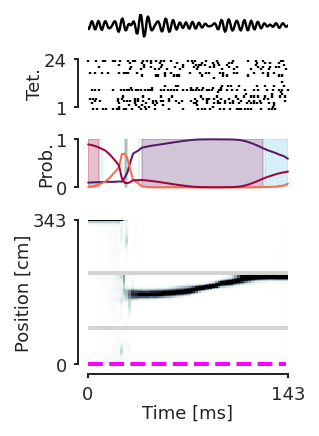

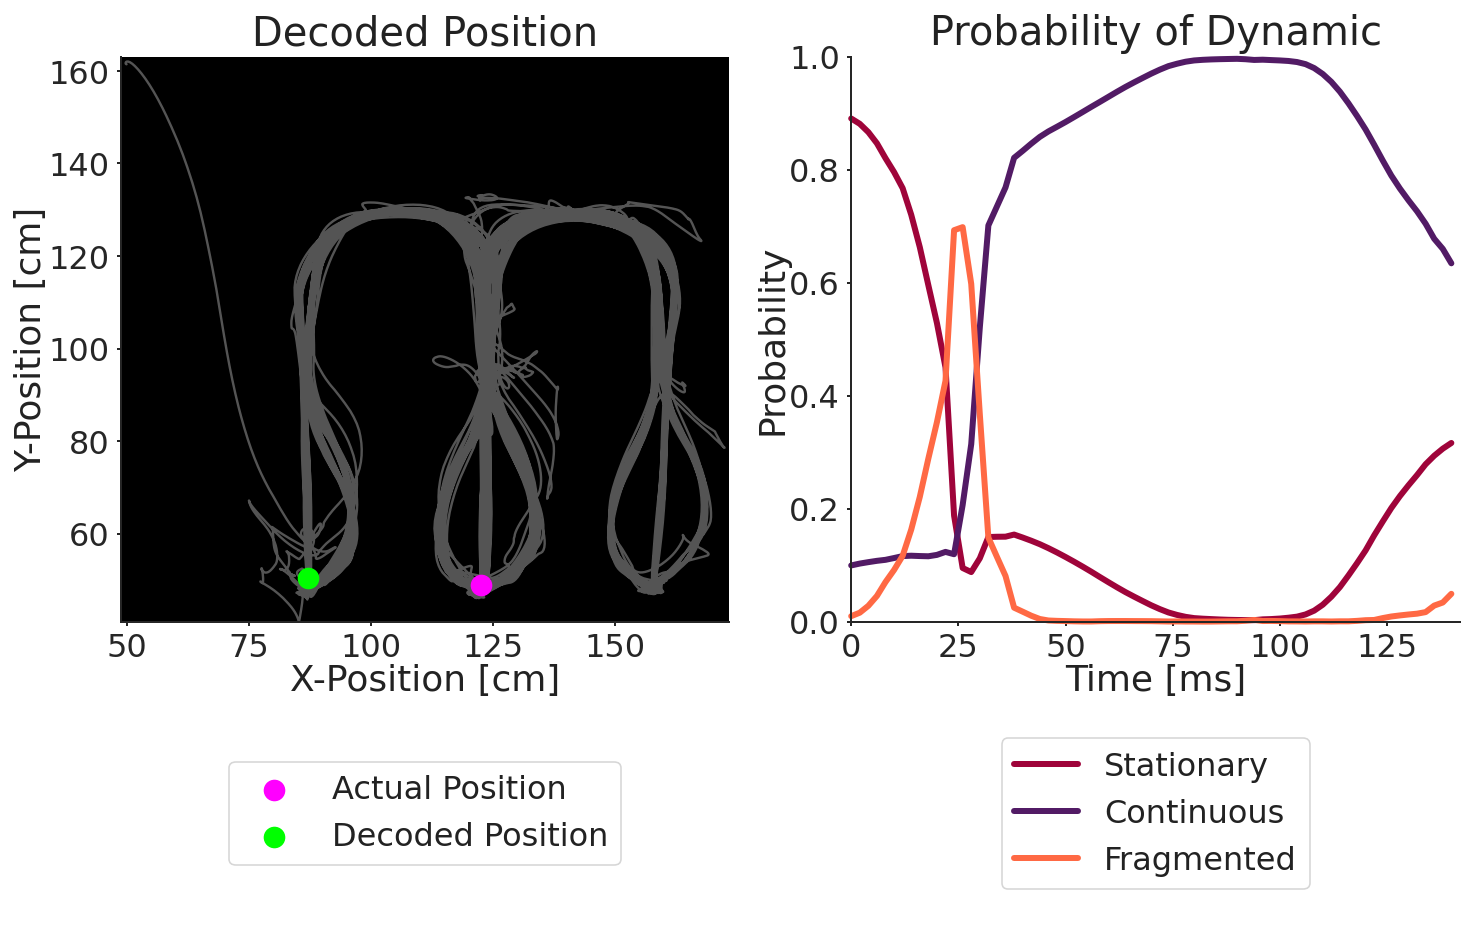

In [16]:
epoch_key = "remy", 37, 4
ripple_number = 50

plot_ripple_figure_1D(epoch_key, ripple_number)

Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Bond/bonDIO08.mat
No DIO file found, using distance from well to segment trials
Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Bond/bonDIO08.mat
No DIO file found, inferring correct inbound/outbound from task rules
Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Bond/bonDIO08.mat
No DIO file found, using distance from well to segment trials
Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Bond/bonDIO08.mat
No DIO file found, inferring correct inbound/outbound from task rules


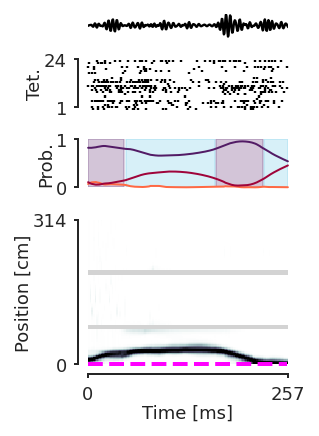

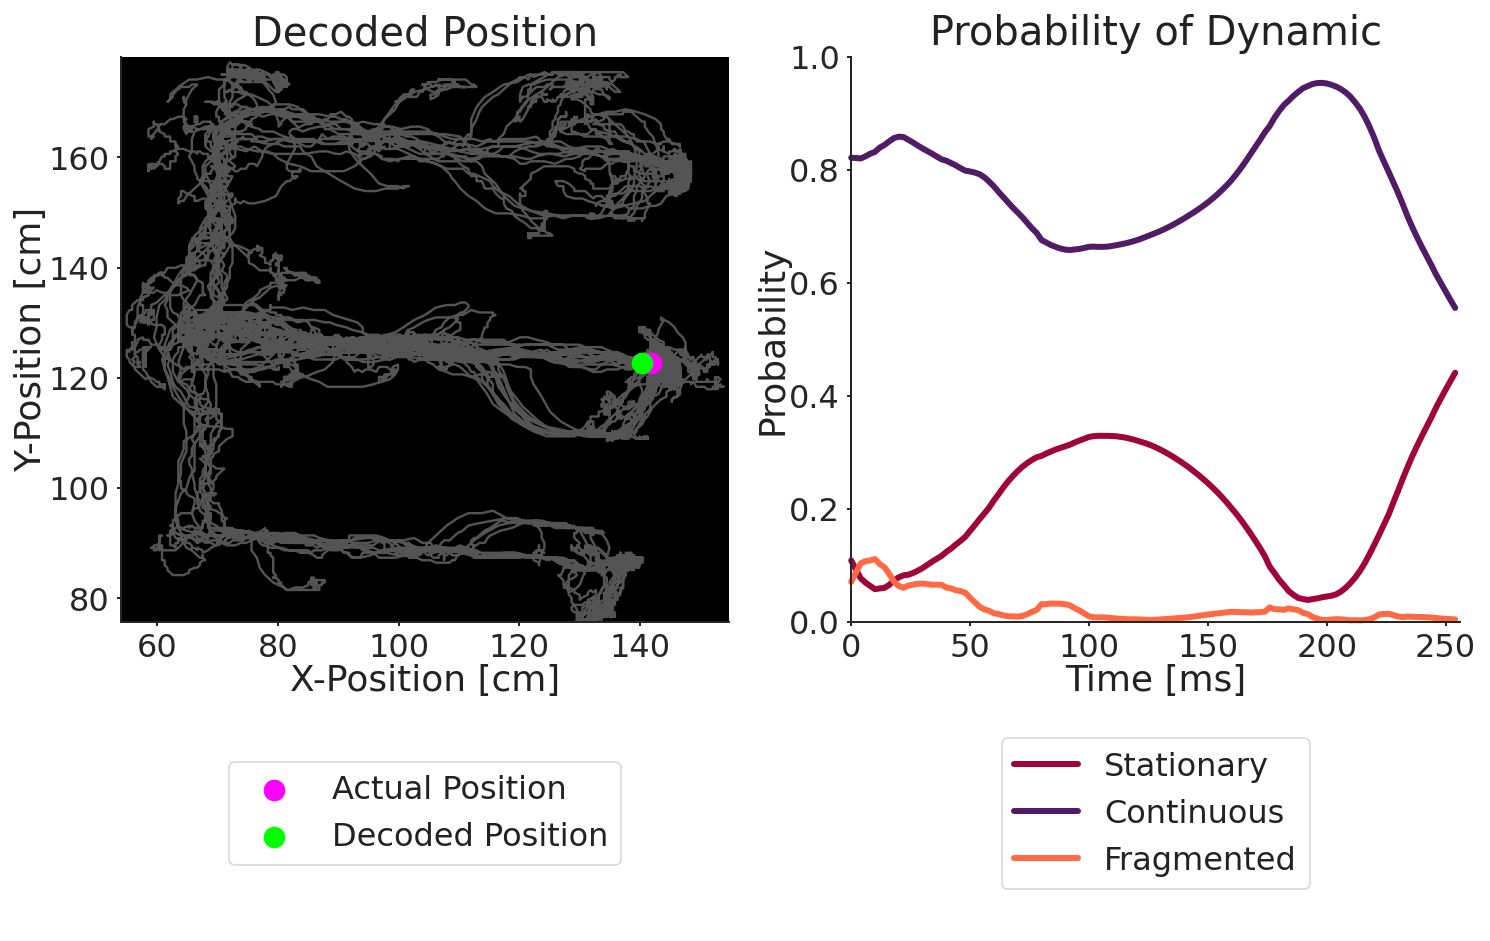

In [17]:
epoch_key = "bon", 8, 6
ripple_number = 11

plot_ripple_figure_1D(epoch_key, ripple_number)

Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Frank/fraDIO04.mat
No DIO file found, using distance from well to segment trials
Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Frank/fraDIO04.mat
No DIO file found, inferring correct inbound/outbound from task rules
Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Frank/fraDIO04.mat
No DIO file found, using distance from well to segment trials
Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Frank/fraDIO04.mat
No DIO file found, inferring correct inbound/outbound from task rules


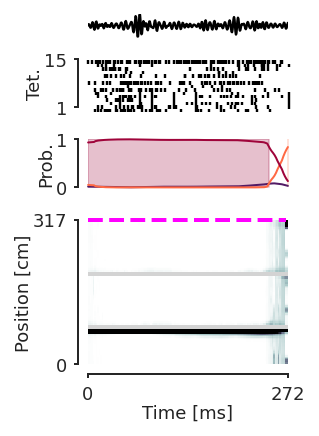

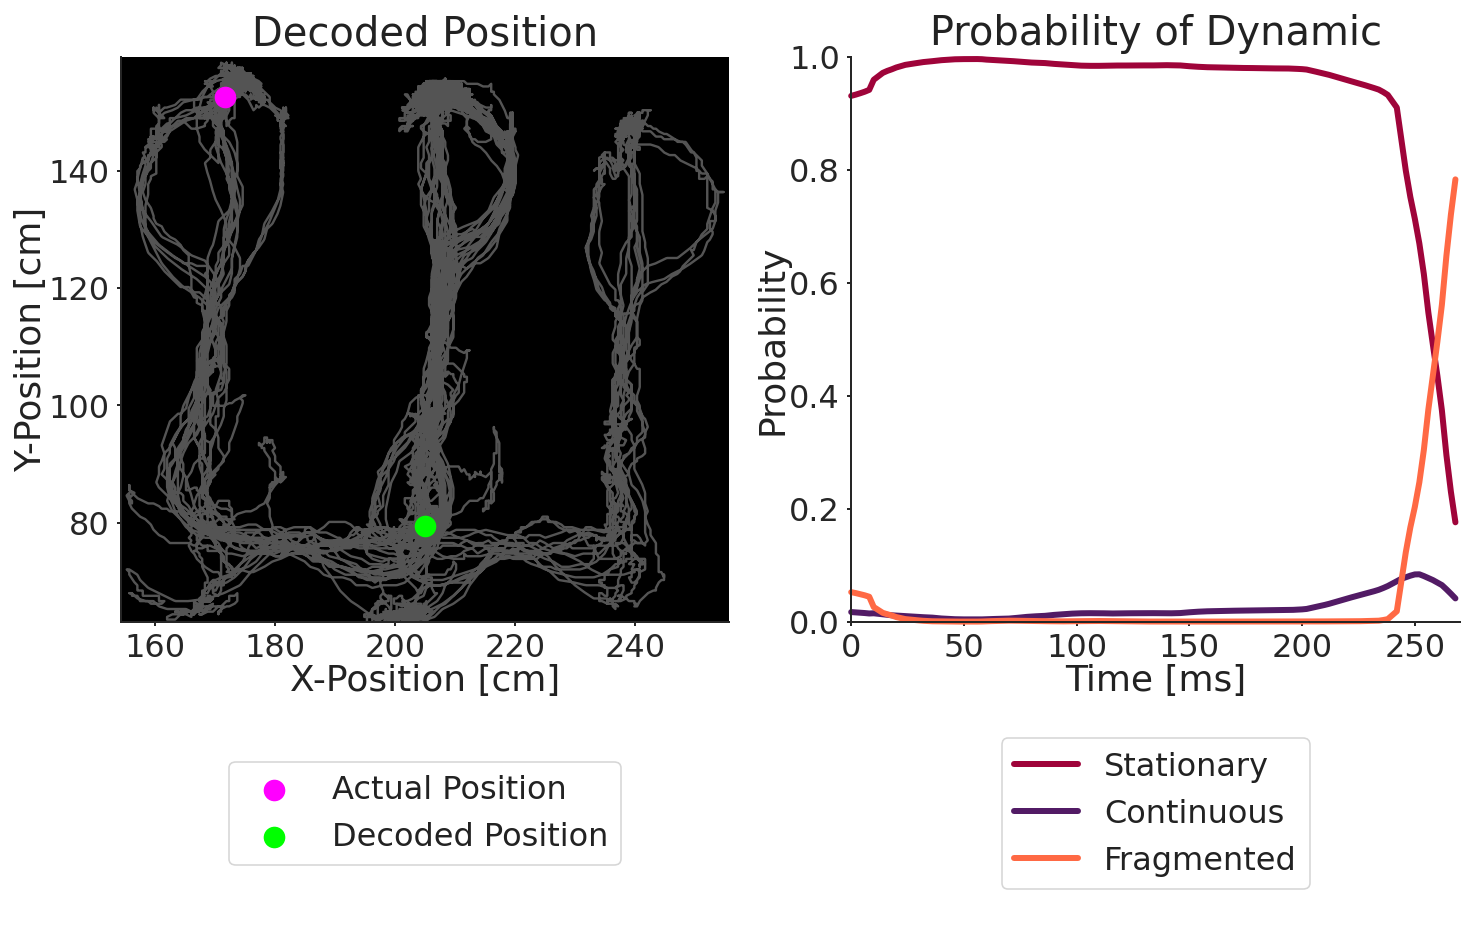

In [21]:
# epoch_key = "remy", 36, 2
# ripple_number = 4
epoch_key = "fra", 4, 4
ripple_number = 151
plot_ripple_figure_1D(epoch_key, ripple_number)

Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Frank/fraDIO11.mat
No DIO file found, using distance from well to segment trials
Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Frank/fraDIO11.mat
No DIO file found, inferring correct inbound/outbound from task rules
Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Frank/fraDIO11.mat
No DIO file found, using distance from well to segment trials
Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Frank/fraDIO11.mat
No DIO file found, inferring correct inbound/outbound from task rules


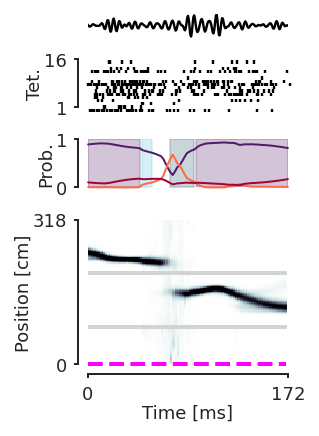

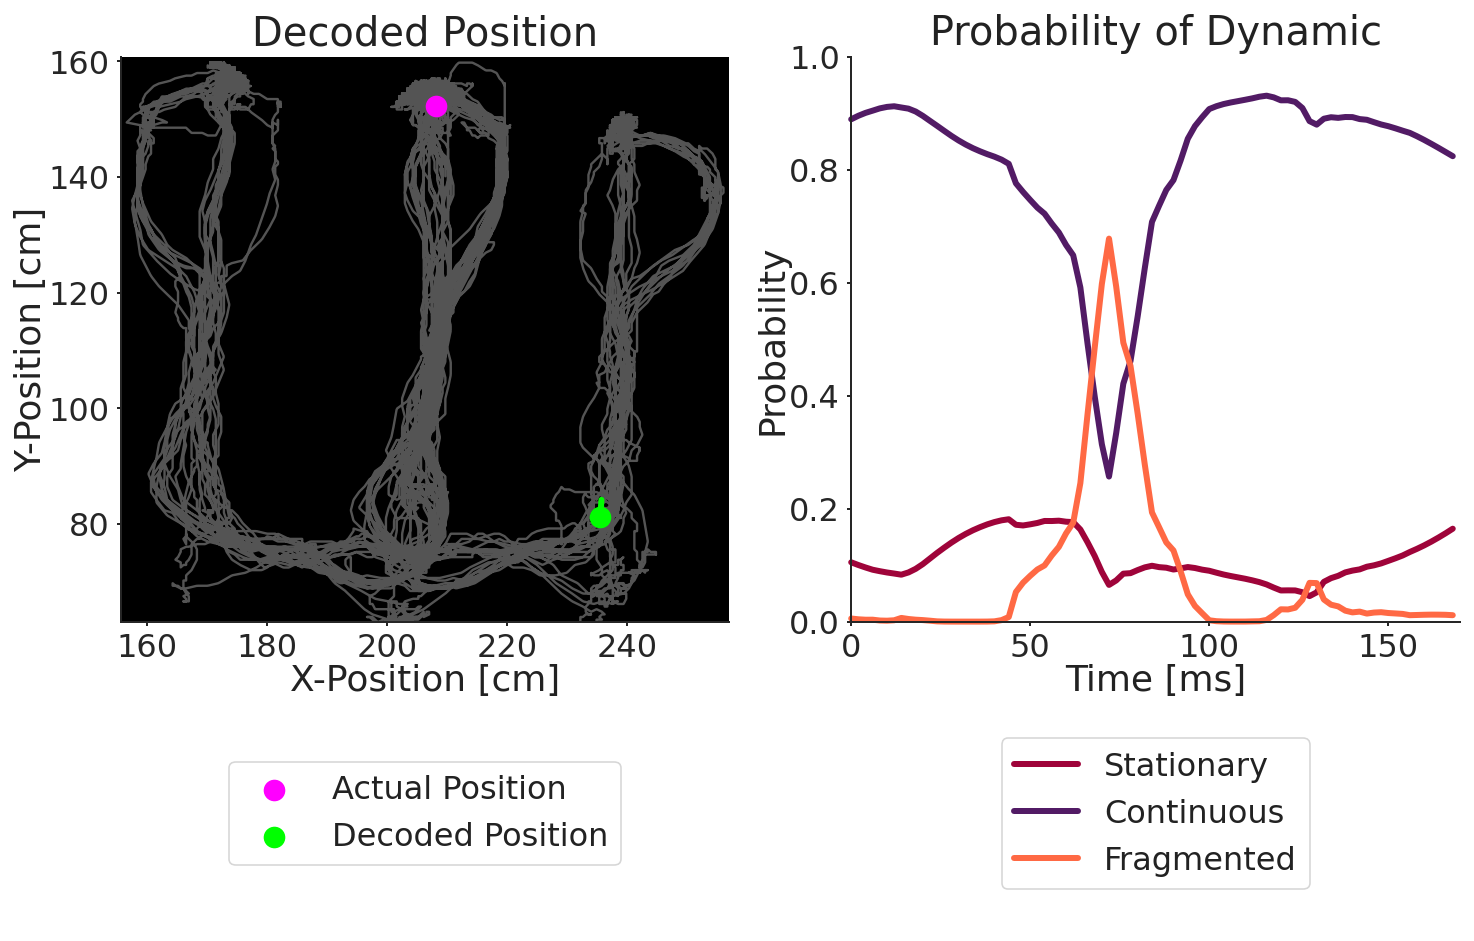

In [19]:
epoch_key = "fra", 11, 4
ripple_number = 1

plot_ripple_figure_1D(epoch_key, ripple_number)

Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Bond/bonDIO06.mat
No DIO file found, using distance from well to segment trials
Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Bond/bonDIO06.mat
No DIO file found, inferring correct inbound/outbound from task rules
Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Bond/bonDIO06.mat
No DIO file found, using distance from well to segment trials
Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Bond/bonDIO06.mat
No DIO file found, inferring correct inbound/outbound from task rules


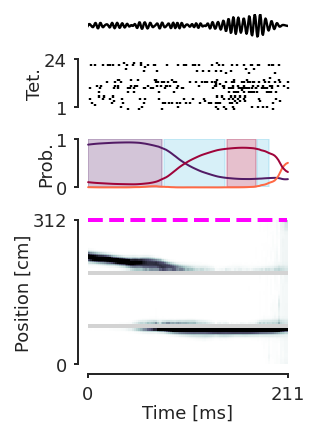

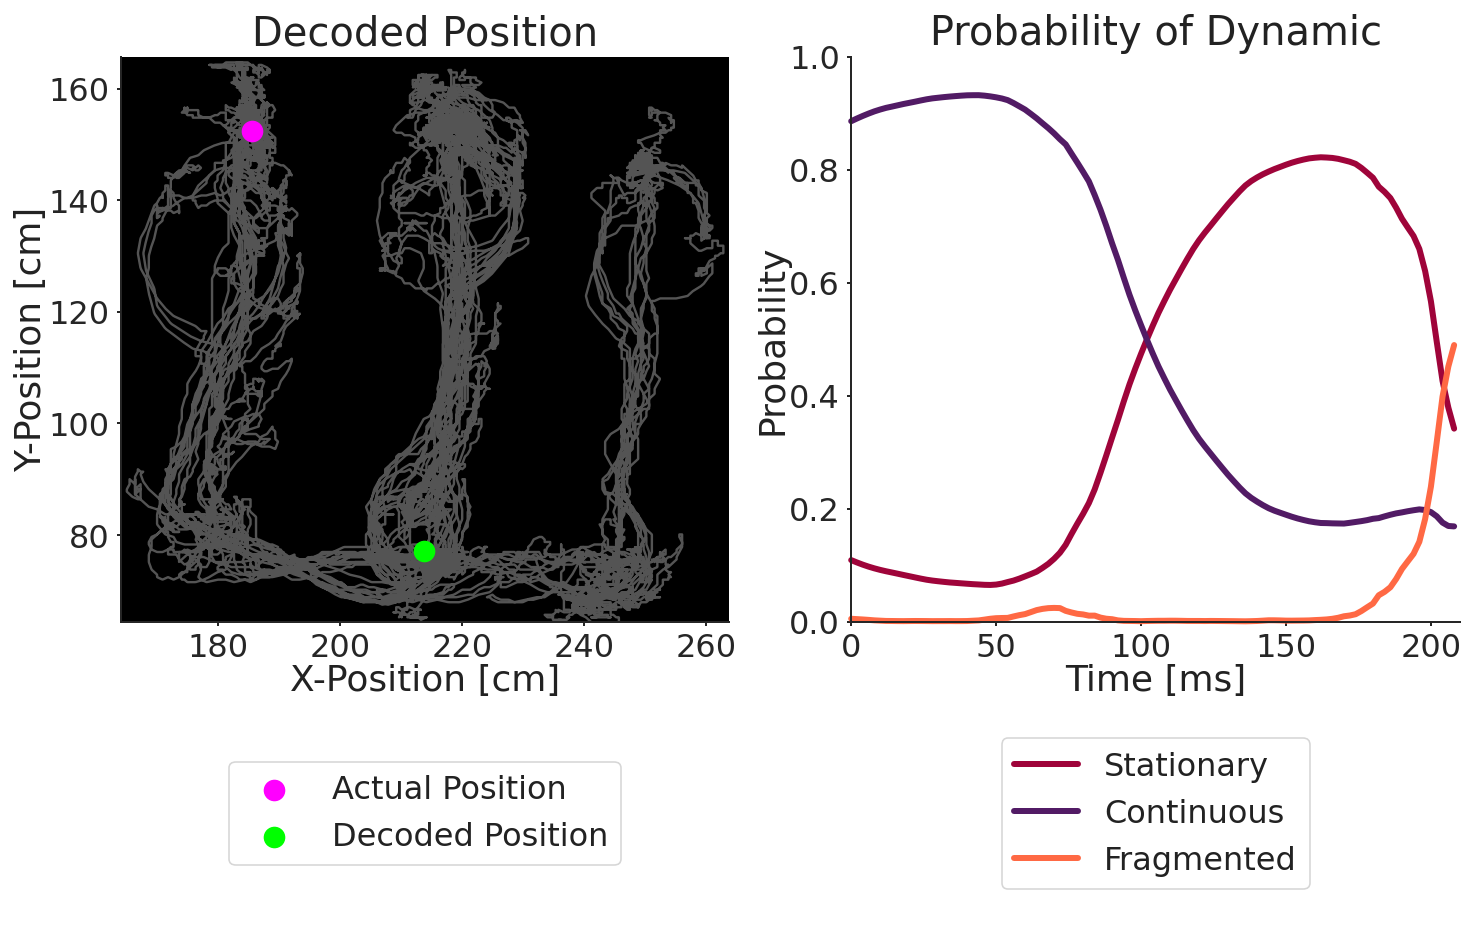

In [20]:
epoch_key = "bon", 6, 2
ripple_number = 41

plot_ripple_figure_1D(epoch_key, ripple_number)

## Population Analysis

In [3]:
from src.analysis import load_all_replay_info
from src.parameters import PROBABILITY_THRESHOLD


replay_info = load_all_replay_info(
    n_unique_spiking=2,
    data_type="clusterless",
    dim="1D",
    probability_threshold=PROBABILITY_THRESHOLD,
    speed_threshold=4,
    exclude_interneuron_spikes=False,
)
replay_info.head()

start_time  \
Animal ID day epoch ripple_number                              
cor       1   2     1              0 days 00:22:39.771534985   
                    2              0 days 00:23:00.114870107   
                    3              0 days 00:23:16.240204859   
                    4              0 days 00:23:21.014871945   
                    5              0 days 00:23:21.862205353   

                                                    end_time  duration  \
Animal ID day epoch ripple_number                                        
cor       1   2     1              0 days 00:22:39.809534988  0.038000   
                    2              0 days 00:23:00.142870110  0.028000   
                    3              0 days 00:23:16.308871531  0.068667   
                    4              0 days 00:23:21.102871953  0.088000   
                    5              0 days 00:23:21.910205357  0.048000   

                                   is_classified  n_unique_spiking  \
Animal ID day epoch ripple_number                                    
cor       1   2     1                       True                10   
                    2                       True                 5   
                    3                       True                 9   
                    4                       True                 9   
                    5                       True                 9   

                                   n_total_spikes  \
Animal ID day epoch ripple_number                   
cor       1   2     1                          21   
                    2                          11   
                    3                          33   
                    4                         115   
                    5                          34   

                                   median_fraction_spikes_under_6_ms  \
Animal ID day epoch ripple_number                                      
cor       1   2     1                                       0.500000   
                    2                                       0.300000   
                    3                                       0.000000   
                    4                                       0.600000   
                    5                                       0.333333   

                                   median_spikes_per_bin  population_rate  \
Animal ID day epoch ripple_number                                           
cor       1   2     1                                1.0        50.239234   
                    2                                1.0        35.714286   
                    3                                1.0        44.117647   
                    4                                2.0       118.801653   
                    5                                1.0        64.393939   

                                   actual_x_position  ...  \
Animal ID day epoch ripple_number                     ...   
cor       1   2     1                     279.996345  ...   
                    2                     289.695552  ...   
                    3                     270.042726  ...   
                    4                     279.300000  ...   
                    5                     279.300000  ...   

                                   center_well_position  choice_position  \
Animal ID day epoch ripple_number                                          
cor       1   2     1                               0.0        73.788252   
                    2                               0.0        73.788252   
                    3                               0.0        73.788252   
                    4                               0.0        73.788252   
                    5                               0.0        73.788252   

                                   left_arm_start  left_well_position  \
Animal ID day epoch ripple_number                                       
cor       1   2     1                    198.8834          301.9951

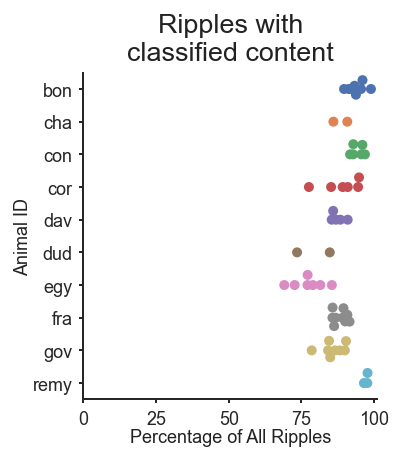

In [4]:
df = (
    replay_info.groupby(["Animal ID", "day"])
    .apply(lambda df: (df["is_classified"]).mean() * 100)
    .rename("Percentage of All Ripples")
)


sns.catplot(
    data=df.reset_index(),
    x="Percentage of All Ripples",
    y="Animal ID",
    ci="sd",
    kind="swarm",
    height=PAGE_HEIGHT / 4,
    size=3,
)
plt.xlim((0, 101))
plt.title("Ripples with\nclassified content")

save_figure("figure3_ripples_with_classified_content")

In [5]:
num = (replay_info.is_classified).sum()
denom = len(replay_info)

print(f"Number classified: {num} / {denom} or {num / denom * 100:0.0f}%\n")

Number classified: 23071 / 25844 or 89%



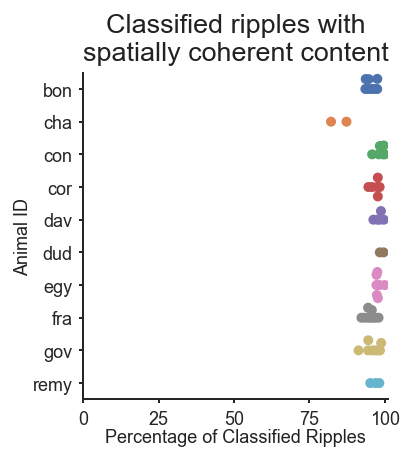

In [6]:
df = (
    replay_info.loc[replay_info.is_classified]
    .groupby(["Animal ID", "day"])
    .apply(
        lambda df: (df["Hover"] | df["Hover-Continuous-Mix"] | df["Continuous"]).mean()
        * 100
    )
    .rename("Percentage of Classified Ripples")
)
for kind in ["swarm"]:
    sns.catplot(
        data=df.reset_index(),
        x="Percentage of Classified Ripples",
        y="Animal ID",
        ci="sd",
        kind=kind,
        height=PAGE_HEIGHT / 4,
        size=3,
    )
    plt.xlim((0, 101))
    plt.title("Classified ripples with\nspatially coherent content")

save_figure("figure3_classified_ripples_with_some_spatially_coherent_content")

In [7]:
classified_replay_info = replay_info.loc[replay_info.is_classified]
spatially_coherent = (
    classified_replay_info["Hover"]
    | classified_replay_info["Hover-Continuous-Mix"]
    | classified_replay_info["Continuous"]
)
num = spatially_coherent.sum()
denom = len(classified_replay_info)

print(f"Number spatially coherent: {num} / {denom} or {num / denom * 100:0.0f}%\n")

Number spatially coherent: 22170 / 23071 or 96%



In [8]:
classified_replay_info = replay_info.loc[replay_info.is_classified]
spatially_coherent = (
    classified_replay_info["Hover"]
    | classified_replay_info["Hover-Continuous-Mix"]
    | classified_replay_info["Continuous"]
)
num = spatially_coherent.sum()
denom = len(replay_info)

print(f"Number spatially coherent: {num} / {denom} or {num / denom * 100:0.0f}%\n")

Number spatially coherent: 22170 / 25844 or 86%



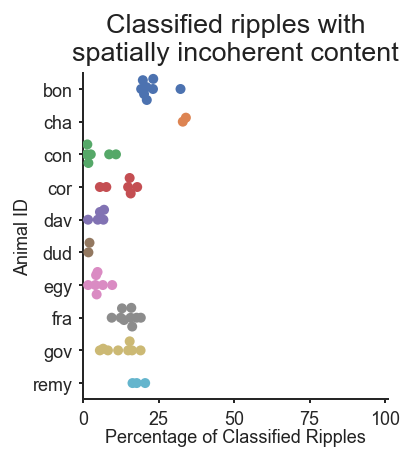

In [9]:
df = (
    replay_info.loc[replay_info.is_classified]
    .groupby(["Animal ID", "day"])
    .apply(lambda df: (df["Fragmented-Continuous-Mix"] | df["Fragmented"]).mean() * 100)
    .rename("Percentage of Classified Ripples")
)
for kind in ["swarm"]:
    sns.catplot(
        data=df.reset_index(),
        x="Percentage of Classified Ripples",
        y="Animal ID",
        ci="sd",
        kind=kind,
        height=PAGE_HEIGHT / 4,
        size=3,
    )
    plt.xlim((0, 101))
    plt.title("Classified ripples with\nspatially incoherent content")

save_figure("figure3_classified_ripples_with_some_spatially_incoherent_content")

In [10]:
spatially_incoherent = (
    classified_replay_info["Fragmented-Continuous-Mix"]
    | classified_replay_info["Fragmented"]
)
num = spatially_incoherent.sum()
denom = len(classified_replay_info)

print(f"Number spatially incoherent: {num} / {denom} or {num / denom * 100:0.0f}%\n")

Number spatially incoherent: 3295 / 23071 or 14%



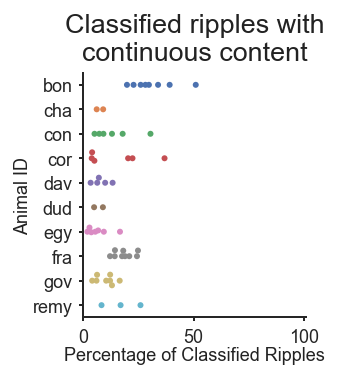

In [11]:
df = (
    replay_info.groupby(["Animal ID", "day"])
    .apply(lambda df: (df["Continuous"]).mean() * 100)
    .rename("Percentage of Classified Ripples")
)


sns.catplot(
    data=df.reset_index(),
    x="Percentage of Classified Ripples",
    y="Animal ID",
    ci="sd",
    kind="swarm",
    height=PAGE_HEIGHT / 4,
    s=3,
)
plt.xlim((0, 101))
plt.title("Classified ripples with\ncontinuous content")
save_figure("figure3_classified_ripples_with_some_continuous_content")

In [12]:
num = classified_replay_info["Continuous"].sum()
denom = len(classified_replay_info)

print(f"Number continuous: {num} / {denom} or {num / denom * 100:0.0f}%\n")

Number continuous: 4449 / 23071 or 19%



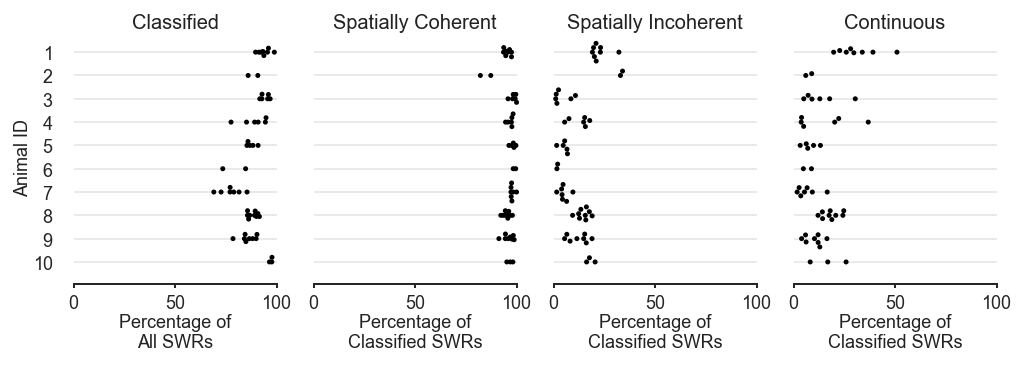

In [13]:
import pandas as pd


fig, axes = plt.subplots(
    1,
    4,
    figsize=(TWO_COLUMN, PAGE_HEIGHT / 4),
    sharex=True,
    sharey=True,
    constrained_layout=True,
)

dot_color = "black"
dot_size = 2.5

# ax 0
df = pd.DataFrame(
    replay_info.groupby(["Animal ID", "day"])
    .apply(lambda df: (df["is_classified"]).mean() * 100)
    .rename("Percentage of All SWRs")
).reset_index()

sns.swarmplot(
    data=df,
    x="Percentage of All SWRs",
    y="Animal ID",
    ax=axes[0],
    size=dot_size,
    color=dot_color,
    clip_on=False,
)
axes[0].set_title("Classified", fontsize=10)
axes[0].grid(True, axis="y", linestyle="-", alpha=0.5)
axes[0].set_xlabel("Percentage of\nAll SWRs")

# ax 1
df = pd.DataFrame(
    replay_info.loc[replay_info.is_classified]
    .groupby(["Animal ID", "day"])
    .apply(
        lambda df: (df["Hover"] | df["Hover-Continuous-Mix"] | df["Continuous"]).mean()
        * 100
    )
    .rename("Percentage of Classified SWRs")
).reset_index()
sns.swarmplot(
    data=df,
    x="Percentage of Classified SWRs",
    y="Animal ID",
    ax=axes[1],
    size=dot_size,
    color=dot_color,
    clip_on=False,
)
axes[1].set_ylabel("")
axes[1].set_xlabel("Percentage of\nClassified SWRs")
axes[1].set_title("Spatially Coherent", fontsize=10)
axes[1].grid(True, axis="y", linestyle="-", alpha=0.5)

# ax 2
df = pd.DataFrame(
    replay_info.loc[replay_info.is_classified]
    .groupby(["Animal ID", "day"])
    .apply(lambda df: (df["Fragmented-Continuous-Mix"] | df["Fragmented"]).mean() * 100)
    .rename("Percentage of Classified SWRs")
).reset_index()
sns.swarmplot(
    data=df,
    x="Percentage of Classified SWRs",
    y="Animal ID",
    ax=axes[2],
    size=dot_size,
    color=dot_color,
    clip_on=False,
)
axes[2].set_ylabel("")
axes[2].set_xlabel("Percentage of\nClassified SWRs")
axes[2].set_title("Spatially Incoherent", fontsize=10)
axes[2].grid(True, axis="y", linestyle="-", alpha=0.5)

# ax 3
df = pd.DataFrame(
    replay_info.groupby(["Animal ID", "day"])
    .apply(lambda df: (df["Continuous"]).mean() * 100)
    .rename("Percentage of Classified SWRs")
).reset_index()

sns.swarmplot(
    data=df,
    x="Percentage of Classified SWRs",
    y="Animal ID",
    ax=axes[3],
    size=dot_size,
    color=dot_color,
    clip_on=False,
)

axes[3].set_xlabel("Percentage of\nClassified SWRs")
axes[3].set_ylabel("")
axes[3].set_title("Continuous", fontsize=10)
axes[3].grid(True, axis="y", linestyle="-", alpha=0.5)
plt.xlim((0, 100))
sns.despine(offset=5)
for ind in range(0, 4):
    axes[ind].spines["left"].set_visible(False)
    axes[ind].tick_params(left=False)
n_animals = replay_info.reset_index()["Animal ID"].unique().size
axes[0].set_yticklabels(np.arange(n_animals) + 1)
save_figure(os.path.join(FIGURE_DIR, "Figure3", "figure3_population_analysis"))

## 95 threshold

In [7]:
from src.analysis import load_all_replay_info


replay_info = load_all_replay_info(
    n_unique_spiking=2,
    data_type="clusterless",
    dim="1D",
    probability_threshold=0.95,
    speed_threshold=4,
    exclude_interneuron_spikes=False,
)
replay_info.head()

start_time  \
Animal ID day epoch ripple_number                              
cor       1   2     1              0 days 00:22:39.771534985   
                    2              0 days 00:23:00.114870107   
                    3              0 days 00:23:16.240204859   
                    4              0 days 00:23:21.014871945   
                    5              0 days 00:23:21.862205353   

                                                    end_time  duration  \
Animal ID day epoch ripple_number                                        
cor       1   2     1              0 days 00:22:39.809534988  0.038000   
                    2              0 days 00:23:00.142870110  0.028000   
                    3              0 days 00:23:16.308871531  0.068667   
                    4              0 days 00:23:21.102871953  0.088000   
                    5              0 days 00:23:21.910205357  0.048000   

                                   is_classified  n_unique_spiking  \
Animal ID day epoch ripple_number                                    
cor       1   2     1                       True                10   
                    2                       True                 5   
                    3                       True                 9   
                    4                       True                 9   
                    5                       True                 9   

                                   n_total_spikes  \
Animal ID day epoch ripple_number                   
cor       1   2     1                          21   
                    2                          11   
                    3                          33   
                    4                         115   
                    5                          34   

                                   median_fraction_spikes_under_6_ms  \
Animal ID day epoch ripple_number                                      
cor       1   2     1                                       0.500000   
                    2                                       0.300000   
                    3                                       0.000000   
                    4                                       0.600000   
                    5                                       0.333333   

                                   median_spikes_per_bin  population_rate  \
Animal ID day epoch ripple_number                                           
cor       1   2     1                                1.0        50.239234   
                    2                                1.0        35.714286   
                    3                                1.0        44.117647   
                    4                                2.0       118.801653   
                    5                                1.0        64.393939   

                                   actual_x_position  ...  \
Animal ID day epoch ripple_number                     ...   
cor       1   2     1                     279.996345  ...   
                    2                     289.695552  ...   
                    3                     270.042726  ...   
                    4                     279.300000  ...   
                    5                     279.300000  ...   

                                   Continuous_spatial_coverage  \
Animal ID day epoch ripple_number                                
cor       1   2     1                                      NaN   
                    2                                      NaN   
                    3                                      NaN   
                    4                                20.660711   
                    5                                      NaN   

                                   Continuous_spatial_coverage_percentage  \
Animal ID day epoch ripple_number                                           
cor       1   2     1                                                 NaN   
                    2                               

In [8]:
from src.parameters import PROCESSED_DATA_DIR
import os


replay_info.to_csv(os.path.join(PROCESSED_DATA_DIR, "replay_info_95.csv"))

In [15]:
num = (replay_info.is_classified).sum()
denom = len(replay_info)

print(f"Number classified: {num} / {denom} or {num / denom * 100:0.0f}%\n")

Number classified: 19478 / 26159 or 74%



In [16]:
classified_replay_info = replay_info.loc[replay_info.is_classified]
spatially_coherent = (
    classified_replay_info["Hover"]
    | classified_replay_info["Hover-Continuous-Mix"]
    | classified_replay_info["Continuous"]
)
num = spatially_coherent.sum()
denom = len(classified_replay_info)

print(f"Number spatially coherent: {num} / {denom} or {num / denom * 100:0.0f}%\n")

Number spatially coherent: 19317 / 19478 or 99%



In [17]:
spatially_incoherent = (
    classified_replay_info["Fragmented-Continuous-Mix"]
    | classified_replay_info["Fragmented"]
)
num = spatially_incoherent.sum()
denom = len(classified_replay_info)

print(f"Number spatially incoherent: {num} / {denom} or {num / denom * 100:0.0f}%\n")

Number spatially incoherent: 490 / 19478 or 3%

